In [1]:
#  gene-specific technical noise variance of gene expression
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
from CellType_PSY import *
from localreg import *
import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# 

In [2]:
JW_ExpMat = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/ExpressionMats/cluster_V3_ExpMat.csv", index_col=0)

In [3]:
JW_ExpMat.head(2)

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
114786,8.241764,8.950873,8.561343,8.135685,8.00458,9.929809,9.905480,8.701526,9.229838,8.938136,...,0.928141,0.917740,1.342611,1.447448,1.168234,0.786823,0.728516,1.946953,0.790298,1.045411
6101,0.021177,0.000000,0.049416,0.025312,0.00000,0.070471,0.073256,0.015195,0.068175,0.000000,...,0.012143,0.017179,0.000000,0.142088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [117]:
All_Genes_ExpMean = []; All_Genes_ExpVar = []
ALL_Genes_Corr = []
for g, row in JW_ExpMat.iterrows():
    exp_values = np.exp2(row.values)
    mean = np.nanmean(exp_values)
    var = np.nanvar(exp_values)
    All_Genes_ExpMean.append(mean)
    All_Genes_ExpVar.append(var)
    if g in g_corr_df.index.values:
        corr = g_corr_df.loc[g, "Corr"]
    else:
        corr = -1
    ALL_Genes_Corr.append(corr)
All_Genes_ExpMean = np.array(All_Genes_ExpMean)
All_Genes_ExpVar = np.array(All_Genes_ExpVar)
ALL_Genes_Corr = np.array(ALL_Genes_Corr)

In [122]:
df = pd.DataFrame(data={"Genes":JW_ExpMat.index.values, "ExpMean":All_Genes_ExpMean,
                       "ExpVar":All_Genes_ExpVar, "STRCorr":ALL_Genes_Corr})
df = df.set_index("Genes")

In [125]:
df2 = df[df["STRCorr"]!=-1]

In [168]:
X = np.log10(df["ExpMean"].values)
Y = np.log10(df["ExpVar"].values+1)
df3 = df2[df2["STRCorr"]>0.3]
X3 = np.log10(df3["ExpMean"].values)
Y3 = np.log10(df3["ExpVar"].values+1)

df4 = df2[df2["STRCorr"]<0.3]
X4 = np.log10(df4["ExpMean"].values)
Y4 = np.log10(df4["ExpVar"].values+1)

Text(0, 0.5, 'log Var')

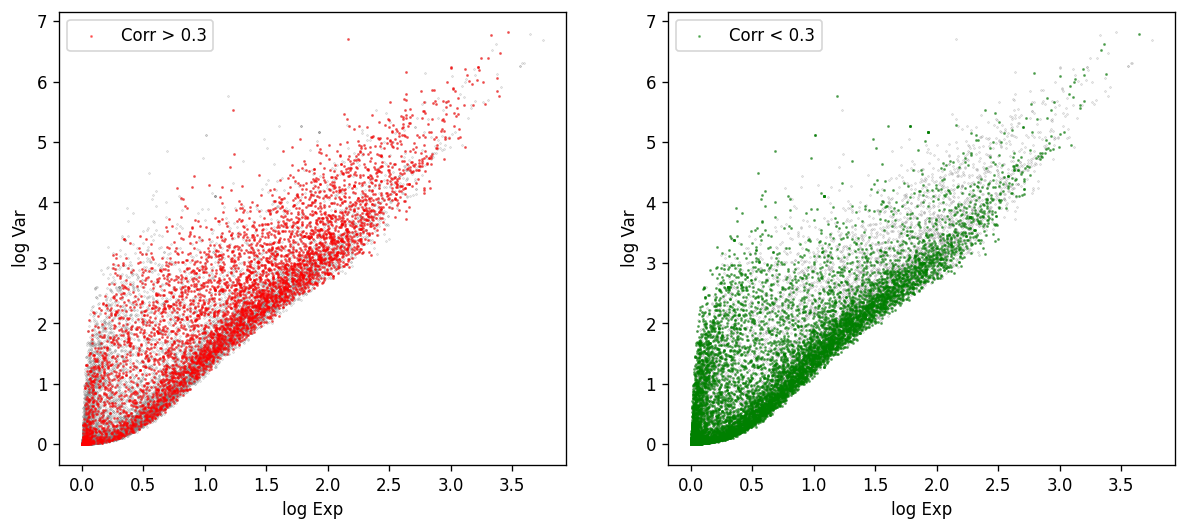

In [170]:
fig, axs = plt.subplots(1,2,dpi=120, figsize=(12,5))
axs[0].scatter(X, Y, s=0.1, alpha=0.5, color="grey")
axs[0].scatter(X3, Y3, s=0.5, alpha=0.5, color="red", label="Corr > 0.3")
axs[0].legend()
axs[0].set_xlabel("log Exp")
axs[0].set_ylabel("log Var")

axs[1].scatter(X, Y, s=0.1, alpha=0.5, color="grey")
axs[1].scatter(X4, Y4, s=0.5, alpha=0.5, color="green", label="Corr < 0.3")
axs[1].legend()
axs[1].set_xlabel("log Exp")
axs[1].set_ylabel("log Var")

In [ ]:
X = np.log2(All_Genes_ExpMean+1)
Y = np.log2(All_Genes_ExpVar+1)

In [ ]:
X_srt_idx = np.argsort(X)
X_sorted = X[X_srt_idx]
Y_sorted = Y[X_srt_idx]

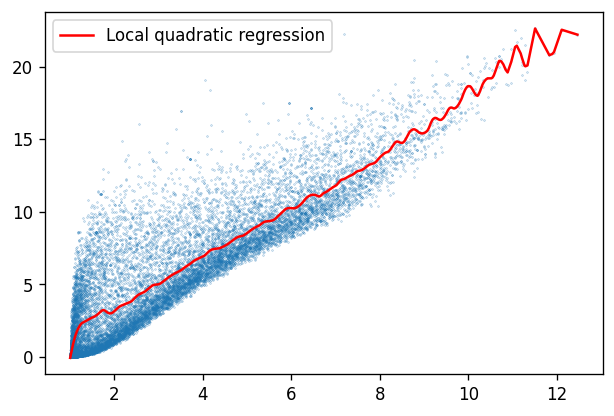

In [54]:
plt.figure(dpi=120)
plt.scatter(X_sorted, Y_sorted, s=0.1, alpha=0.5)

Y2 = localreg(X_sorted, Y_sorted, degree=2, kernel=rbf.tricube, radius=0.3)
plt.plot(X_sorted, Y2, label='Local quadratic regression', color="red")
plt.legend()

In [85]:
Y2_orginal = np.exp2(Y2)-1
Y2_orginal[Y2_orginal<0]=0

In [86]:
min(Y2_orginal)

0.0

In [87]:
def Cal_Tech_Frac(VarTech, VarTotal):
    res = []
    for v1, v2 in zip(VarTech, VarTotal):
        if v2 == 0:
            res.append(1)
        else:
            res.append(v1/v2)
    return np.array(res)
TechVarFrac = Cal_Tech_Frac(Y2_orginal, All_Genes_ExpVar[X_srt_idx])

In [91]:
TechVarFrac[TechVarFrac>1]=1

In [92]:
TechVarFrac

array([1.        , 1.        , 1.        , ..., 1.        , 0.99969707,
       1.        ])

In [93]:
print(min(TechVarFrac), max(TechVarFrac))

0.0 1.0


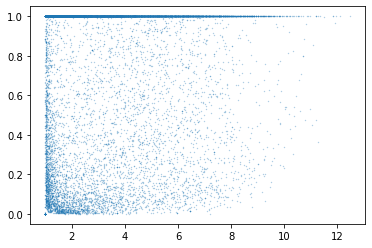

In [94]:
plt.scatter(X_sorted, TechVarFrac, s=0.1, alpha=0.5)

In [57]:
TechVar = Y * TechVarFrac

/tmp/ipykernel_3493894/1323584231.py:1: RuntimeWarning: invalid value encountered in multiply
  TechVar = Y * TechVarFrac


In [100]:
genes = JW_ExpMat.index.values
genes_sorted = genes[X_srt_idx]
print(len(genes_sorted), len(TechVar))

17938 17938


In [103]:
gene_techVar_dict = dict(zip(genes_sorted, TechVarFrac))

In [95]:
# next step: check corr ISH/SC has alterd var frac?

In [171]:
g_corr_df = pd.read_csv("dat/ISH_MERFISH_Gene_CorssSTR_Corr.csv", index_col="Genes")

In [172]:
g_corr_df.head(2)

,Corr,Symbol,ISH_exp,MERFISH_exp
Genes,,,,
27132,0.939306,CPNE7,2.433352,1.604471
140885,0.929601,SIRPA,2.349709,4.576162


In [106]:
for i, row in g_corr_df.iterrows():
    g_corr_df.loc[i, "techVarFrac"] = gene_techVar_dict[i]

Text(0, 0.5, 'Frac Tech Var')

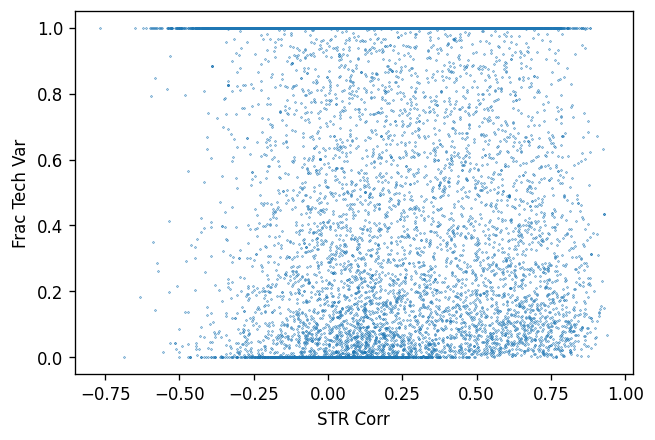

In [167]:
plt.figure(dpi=120)
plt.scatter(g_corr_df["Corr"].values, g_corr_df["techVarFrac"].values, s=0.1)
plt.xlabel("STR Corr")
plt.ylabel("Frac Tech Var")

In [110]:
g_corr_df

,Corr,Symbol,ISH_exp,MERFISH_exp,techVarFrac
Genes,,,,,
27132,0.939306,CPNE7,2.433352,1.604471,0.068535
140885,0.929601,SIRPA,2.349709,4.576162,0.435323
10326,0.929601,SIRPB1,2.349709,4.576162,0.435323
55423,0.929601,SIRPG,2.349709,4.576162,0.435323
815,0.929302,CAMK2A,3.281885,4.878512,0.148271
...,...,...,...,...,...
92017,-0.621576,SNX29,0.279493,4.272352,1.000000
5608,-0.632962,MAP2K6,3.048732,2.896152,0.183015
25,-0.650491,ABL1,2.080494,3.679272,1.000000


# Use V2 V3 Diff to denoise

In [175]:
V2_ExpMat = pd.read_csv("dat/ExpressionMats/Subclass_V2_ExpMat.csv", index_col=0)
V3_ExpMat = pd.read_csv("dat/ExpressionMats/Subclass_V3_ExpMat.csv", index_col=0)

In [176]:
V2_ExpMat.head(2)

,001 CLA-EPd-CTX Car3 Glut,002 IT EP-CLA Glut,003 L5/6 IT TPE-ENT Glut,004 L6 IT CTX Glut,005 L5 IT CTX Glut,006 L4/5 IT CTX Glut,007 L2/3 IT CTX Glut,008 L2/3 IT ENT Glut,009 L2/3 IT PIR-ENTl Glut,010 IT AON-TT-DP Glut,...,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN,336 Monocytes NN,337 DC NN,338 Lymphoid NN
114786,7.449768,8.808967,8.482787,8.144073,7.836571,7.618347,7.465959,8.198997,7.778592,8.631422,...,3.224299,1.906158,1.767038,1.669184,1.96909,1.72188,1.846877,1.249038,1.164145,1.936
6101,0.013979,0.029803,0.028681,0.024239,0.024815,0.023024,0.021153,0.026609,0.022384,0.051599,...,0.000000,0.000000,0.029139,0.000000,0.19719,0.01272,0.000000,0.000000,0.000000,0.000


In [177]:
V3_ExpMat.head(2)

,001 CLA-EPd-CTX Car3 Glut,002 IT EP-CLA Glut,003 L5/6 IT TPE-ENT Glut,004 L6 IT CTX Glut,005 L5 IT CTX Glut,006 L4/5 IT CTX Glut,007 L2/3 IT CTX Glut,008 L2/3 IT ENT Glut,009 L2/3 IT PIR-ENTl Glut,010 IT AON-TT-DP Glut,...,329 ABC NN,330 VLMC NN,331 Peri NN,332 SMC NN,333 Endo NN,334 Microglia NN,335 BAM NN,336 Monocytes NN,337 DC NN,338 Lymphoid NN
114786,8.393236,9.637897,9.172872,8.794669,8.577889,8.741415,8.418115,8.942757,9.037723,9.801990,...,3.023453,1.128468,0.882595,0.870327,0.905130,1.128210,0.923004,1.342611,0.959363,0.989624
6101,0.031031,0.066379,0.071647,0.042012,0.042760,0.043536,0.045480,0.097256,0.058467,0.086076,...,0.169042,0.020464,0.007897,0.010771,0.563716,0.010659,0.014630,0.000000,0.014573,0.000000


In [184]:
Corss_CT_Corrs = []
for g, row in V2_ExpMat.iterrows():
    v2_exps = V2_ExpMat.loc[g, :].values
    v3_exps = V3_ExpMat.loc[g, :].values
    r,p = spearmanr(v2_exps, v3_exps, nan_policy="omit")
    #r,p = spearmanr(v2_exps, v3_exps)
    Corss_CT_Corrs.append(r)

In [ ]:
r,p = spearmanr(v2_exps, v3_exps, nan_policy='omit')

(array([   7.,   92.,  755., 1615., 2316., 3307., 4383., 3694., 1581.,
         154.]),
 array([-0.30977306, -0.18825839, -0.06674371,  0.05477097,  0.17628564,
         0.29780032,  0.41931499,  0.54082967,  0.66234434,  0.78385902,
         0.9053737 ]),
 <BarContainer object of 10 artists>)

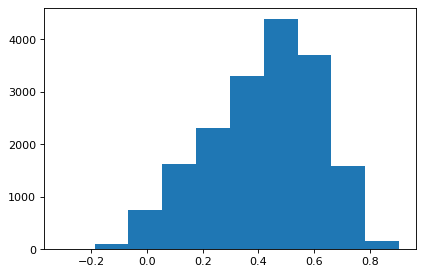

In [185]:
plt.hist(Corss_CT_Corrs)

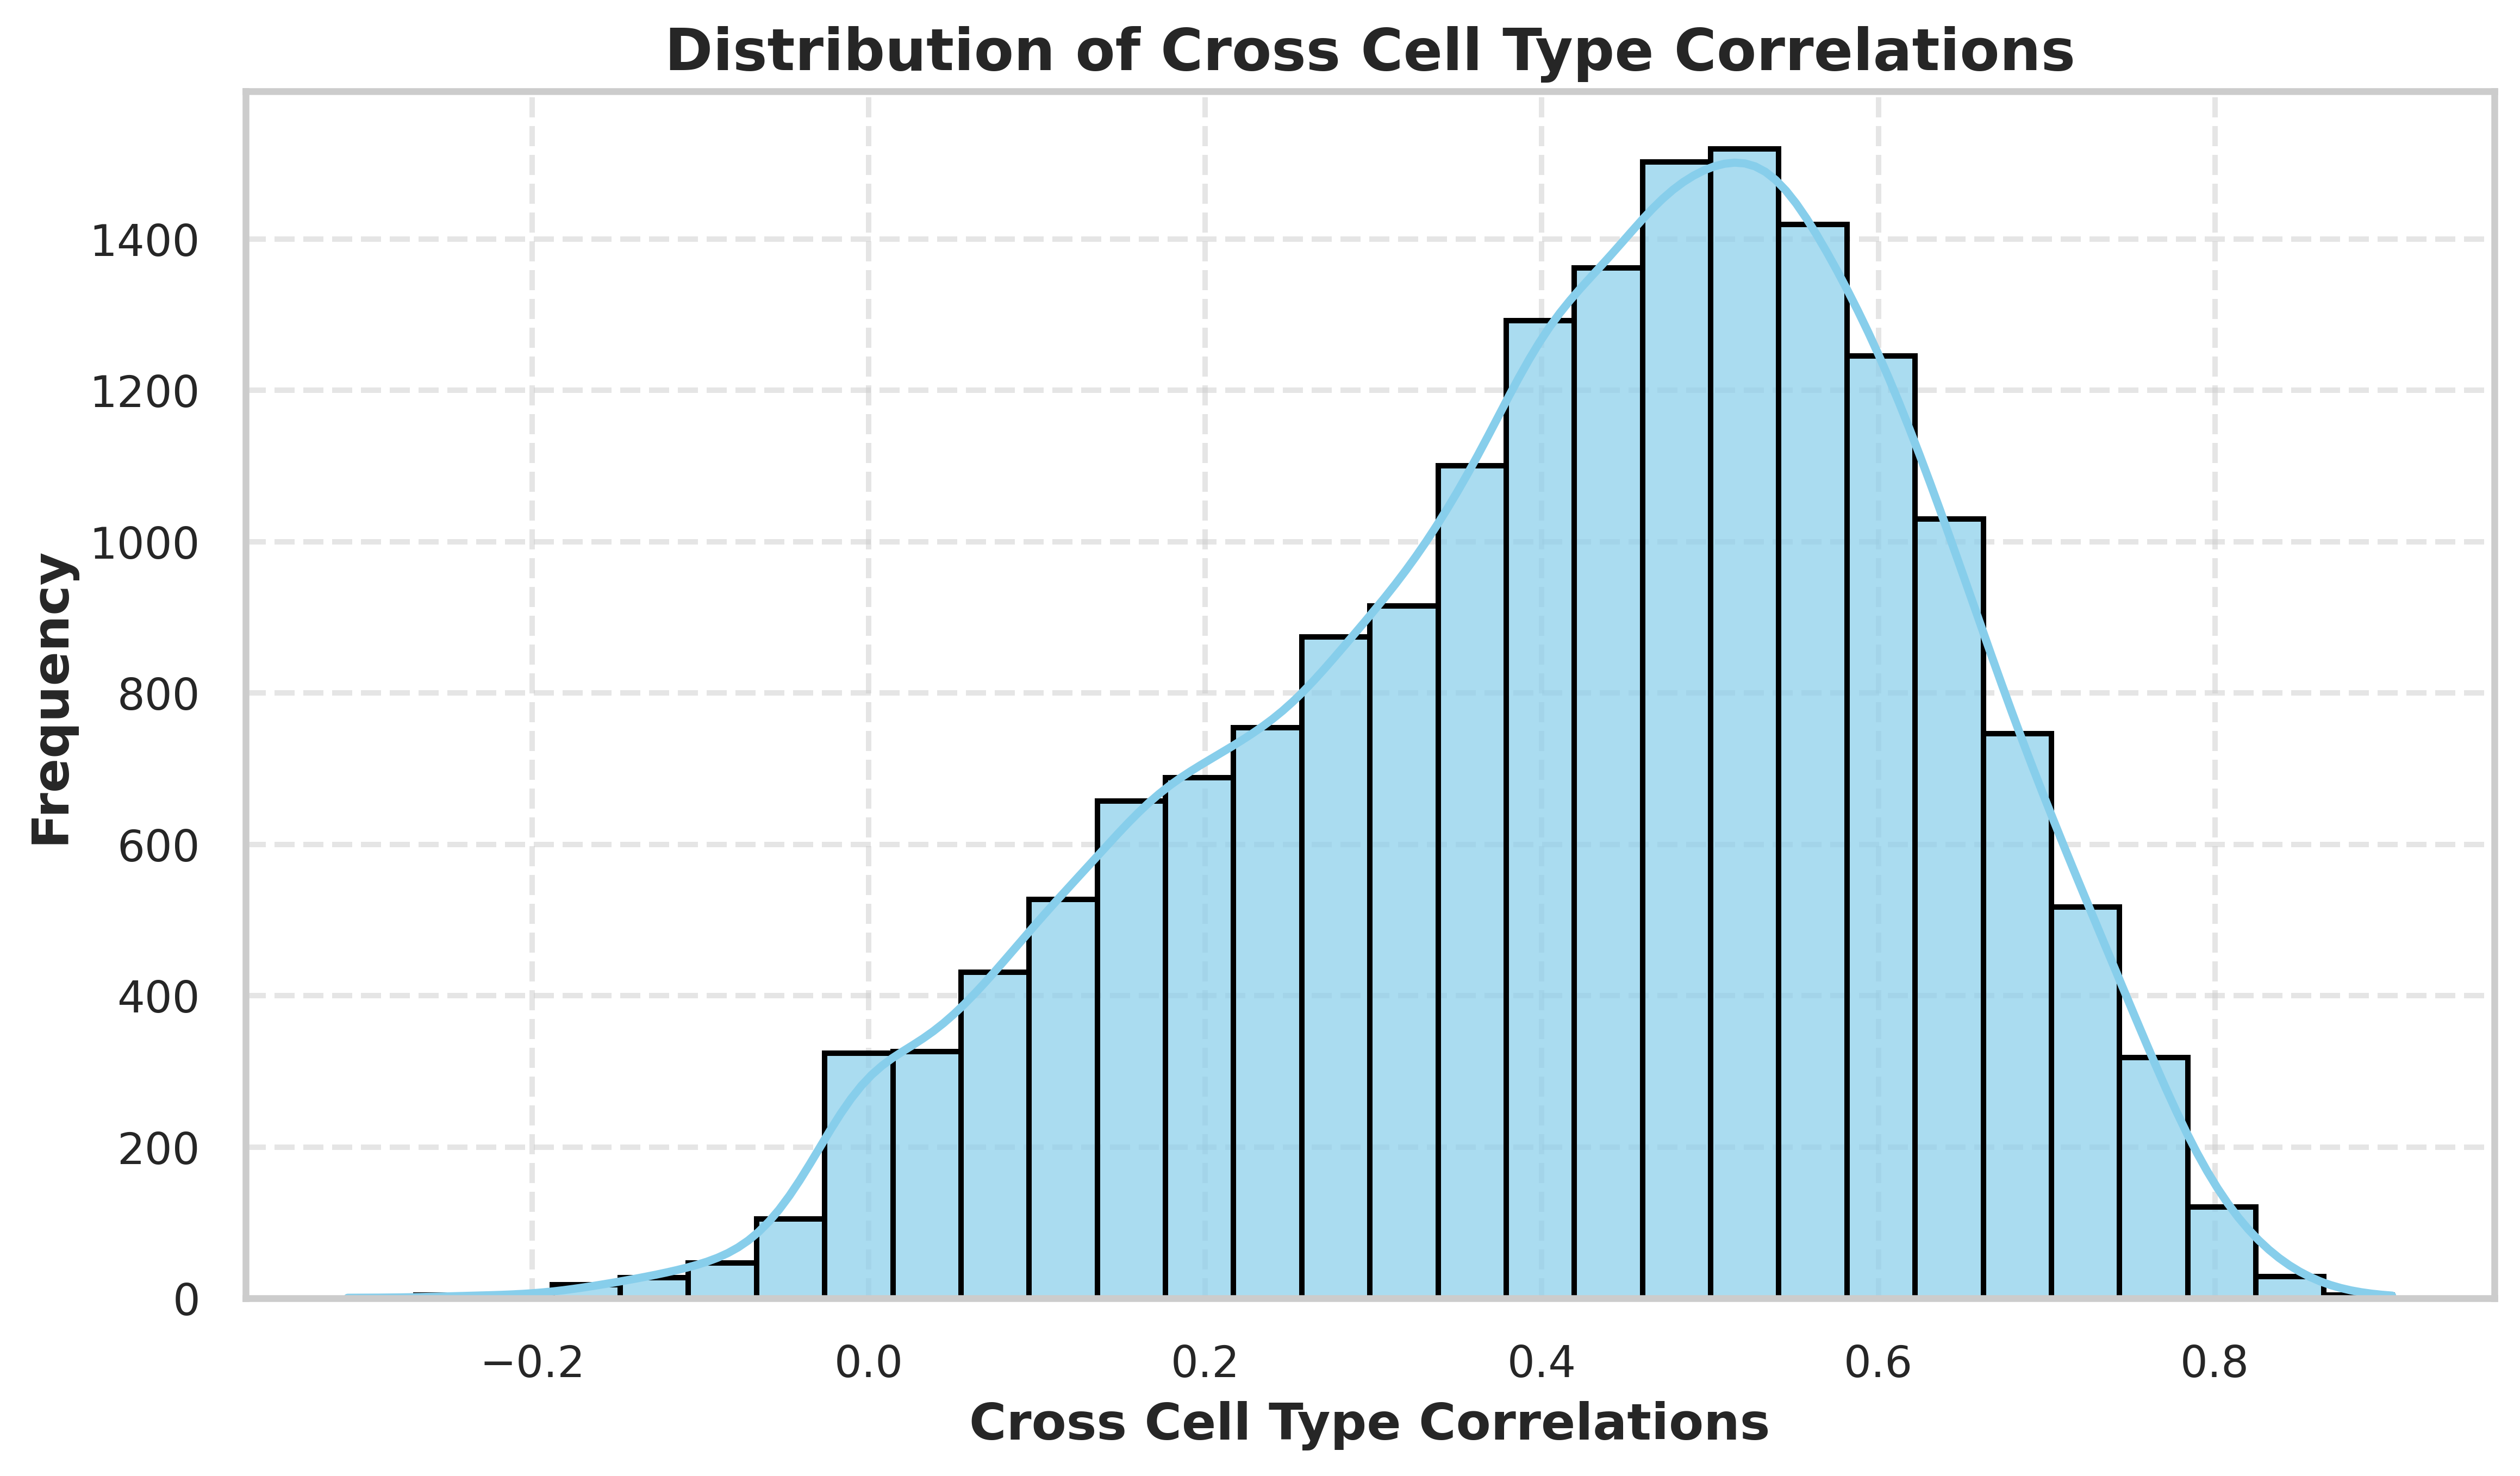

In [197]:
sns.set(style="whitegrid", context="talk")

# Create the figure
plt.figure(dpi=480, figsize=(10, 6))

# Plot the histogram with improved aesthetics
sns.histplot(Corss_CT_Corrs, bins=30, kde=True, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title with appropriate font sizes
plt.xlabel("Cross Cell Type Correlations", fontsize=14, weight='bold')
plt.ylabel("Frequency", fontsize=14, weight='bold')
plt.title("Distribution of Cross Cell Type Correlations", fontsize=16, weight='bold')

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Improve tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Use tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

In [188]:
ISH_SC_CorrDF = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/ISH_MERFISH_Gene_CorssSTR_Corr.csv", index_col=0)

In [189]:
ISH_SC_CorrDF.head(2)

,Corr,Symbol,ISH_exp,MERFISH_exp
Genes,,,,
27132,0.939306,CPNE7,2.433352,1.604471
140885,0.929601,SIRPA,2.349709,4.576162


In [190]:
for g, row in ISH_SC_CorrDF.iterrows():
    v2_exps = V2_ExpMat.loc[g, :].values
    v3_exps = V3_ExpMat.loc[g, :].values
    r,p = spearmanr(v2_exps, v3_exps, nan_policy="omit")
    ISH_SC_CorrDF.loc[g, "V2_V3_CT_Corr"] = r

In [191]:
ISH_SC_CorrDF.head(2)

,Corr,Symbol,ISH_exp,MERFISH_exp,V2_V3_CT_Corr
Genes,,,,,
27132,0.939306,CPNE7,2.433352,1.604471,0.731995
140885,0.929601,SIRPA,2.349709,4.576162,0.768766


Text(0, 0.5, 'V2 V3 CT Corr')

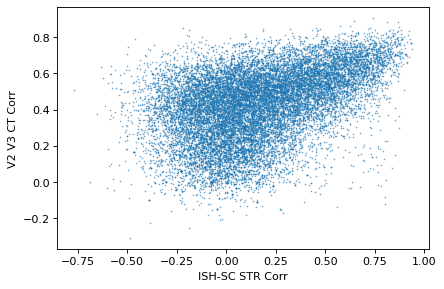

In [194]:
plt.scatter(ISH_SC_CorrDF["Corr"].values, ISH_SC_CorrDF["V2_V3_CT_Corr"].values, s=0.1)
plt.xlabel("ISH-SC STR Corr")
plt.ylabel("V2 V3 CT Corr")

In [196]:
pearsonr(ISH_SC_CorrDF["Corr"].values, ISH_SC_CorrDF["V2_V3_CT_Corr"].values)

(0.435536953611528, 0.0)

In [195]:
ISH_SC_CorrDF.to_csv("dat/ISH_MERFISH_Gene_CorssSTR_Corr.v2.csv")

In [198]:
15000 / 200

75.0

In [199]:
15000 * 10

150000

In [201]:
150000 / 12800 * 32

375.0

In [202]:
15000 / 160

93.75

In [203]:
93 * (0.75395 * 1 + 0.20105 * 4 + 0.045 * 32)

278.82795

In [206]:
93 * (0.75395 * 600 + 0.20105 * 3200 + 0.045 * 35000) * 0.85

211121.2065

In [208]:
211121.2065 / 12800 * 32

527.80301625

In [209]:
(91 * 600 + 2 * 35000) * 0.85

105910.0

In [210]:
105910.0 / 12800 * 32

264.775